In [1]:
import gc
import time
from tqdm import tqdm
import cv2
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import Callback

from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_0.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_1.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_2.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_3.feather


In [2]:
train_target = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv', index_col='image_id')

In [3]:
rootLB = LabelBinarizer()
vowelLB = LabelBinarizer()
consonantLB = LabelBinarizer()
rootLB.fit(train_target['grapheme_root'])
vowelLB.fit(train_target['vowel_diacritic'])
consonantLB.fit(train_target['consonant_diacritic'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

# Custom modules

## Custom metric callback

In [4]:
class validation_recall(keras.callbacks.Callback):
    
    def __init__(self, validation_data=()):
        super(keras.callbacks.Callback, self).__init__()
        self.X_val, self.y_val = validation_data
    
    def on_epoch_end(self, epoch, logs={}):

        root_val = self.y_val[0]
        vowel_val = self.y_val[1]
        consonant_val = self.y_val[2]
        
        # Predictions on validation set for the 3 targets 
        #(+ one hot encoding)
        preds = self.model.predict(self.X_val)
        
        root_preds = np.zeros_like(preds[0])
        root_preds[np.arange(len(preds[0])), 
                   preds[0].argmax(axis=1)] = 1
        
        vowel_preds = np.zeros_like(preds[1])
        vowel_preds[np.arange(len(preds[1])), 
                    preds[1].argmax(axis=1)] = 1
        
        consonant_preds = np.zeros_like(preds[2])
        consonant_preds[np.arange(len(preds[2])), 
                        preds[2].argmax(axis=1)] = 1
        
        # Recall calculation for the 3 targets
        root_recall = recall_score(root_val, root_preds, 
                                   average='macro')
        vowel_recall = recall_score(vowel_val, vowel_preds, 
                                    average='macro')
        consonant_recall = recall_score(consonant_val, consonant_preds, 
                                        average='macro')
        final_score = np.average([root_recall, vowel_recall, 
                                  consonant_recall], weights=[2,1,1])
        
        # Displaying scores at the end of each epoch
        print(' - root_recall: {0:.4f}'.format(root_recall)+\
              ' - vowel_recall: {0:.4f}'.format(vowel_recall)+\
              ' - consonant_recall: {0:.4f}'.format(consonant_recall)+\
              ' - final_score: {0:.4f}'.format(final_score))

        # Saving scores in logs history
        logs['root_recall'] = root_recall
        logs['vowel_recall'] = vowel_recall
        logs['consonant_recall'] = consonant_recall
        logs['final_score'] = final_score
        
        del root_val
        del vowel_val
        del consonant_val
        del preds 
        del root_preds 
        del vowel_preds
        del consonant_preds
        gc.collect()

## Custom data loader

Keras DataGenerator modified for multi-outputs model taken from [this very interesting notebook](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn#Basic-Model) from Kaushal Shah. It will allow to generate a batch of data to feed the model while training to avoid memory shortage.

In [5]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, 
                                         batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

## Resizing function

In [6]:
HEIGHT = 137
WIDTH = 236
CROP_SIZE = 80

In [7]:
def crop_and_resize_images(df, resized_df, resize_size = CROP_SIZE):
    cropped_imgs = {}
    for img_id in tqdm(range(df.shape[0])):
        img = resized_df[img_id]
        _, thresh = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        idx = 0 
        ls_xmin = []
        ls_ymin = []
        ls_xmax = []
        ls_ymax = []
        for cnt in contours:
            idx += 1
            x,y,w,h = cv2.boundingRect(cnt)
            ls_xmin.append(x)
            ls_ymin.append(y)
            ls_xmax.append(x + w)
            ls_ymax.append(y + h)
        xmin = min(ls_xmin)
        ymin = min(ls_ymin)
        xmax = max(ls_xmax)
        ymax = max(ls_ymax)

        roi = img[ymin:ymax,xmin:xmax]
        resized_roi = cv2.resize(roi, (resize_size, resize_size))
        cropped_imgs[df.image_id[img_id]] = resized_roi.reshape(-1)
        
    resized = pd.DataFrame(cropped_imgs).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized #out_df

# Model definition

In [8]:
def create_multi_outputs_model():
    
    inputs = Input(shape=(80,80,1))
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(3, 3), padding='valid')(x)
    #x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    
    root_out = Dense(168, activation='softmax', name='root_output')(x)
    vowel_out = Dense(11, activation='softmax', name='vowel_output')(x)
    consonant_out = Dense(7, activation='softmax', name='consonant_output')(x)

    model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out])
    
    return model

# Training function :

This training function is using the following process :
* Loading a set of images and targets data (from one of the four images files)
* Reshape images data to numpy array with correct dimensions (100 x 100)
* One hot encoding of the 3 targets
* Separate all sets in two : training set and validation set
* Creating Keras data generators to load data batch by batch in the model
* Train the model


In [9]:
def train_model(model, epochs, batch_size):
    complete_history = []
    for i in range(4):

        # Images + targets loading and merging
        train_data = pd.read_feather('/kaggle/input/bengali-graphemes-'
                                     'croppedresized-100x100-train/'
                                     f'train_data_{i}.feather')
        train_data.set_index(keys=['image_id'], drop=True, inplace=True)
        train_df = pd.merge(train_data, train_target, 
                            on='image_id').drop(['grapheme'], axis=1)
        
        # Deleting previous variables to free up memory
        del train_data
        gc.collect()
        
        # One hot encoding the 3 targets with sklearn LabelBinarizer
        #rootLB = LabelBinarizer()
        #vowelLB = LabelBinarizer()
        #consonantLB = LabelBinarizer()
        rootLabels = rootLB.transform(train_df['grapheme_root'])
        vowelLabels = vowelLB.transform(train_df['vowel_diacritic'])
        consonantLabels = consonantLB.transform(
                          train_df['consonant_diacritic'])

        # Reshape images data to numpy array with same dimensions 
        # as images (80 x 80)
        train_df.drop(['grapheme_root', 'vowel_diacritic', 
                       'consonant_diacritic'], axis=1, inplace=True)
        train_df = train_df / 255
        train_images = train_df.values.reshape(-1, 80, 80, 1)
        
        # Deleting previous variables to free up memory
        del train_df
        gc.collect()

        # Creating Train / validation set for images and 3 targets
        X_train, X_val, y_train_root, y_val_root, y_train_vowel, \
        y_val_vowel, y_train_consonant, y_val_consonant \
        = train_test_split(train_images, rootLabels, vowelLabels, 
                           consonantLabels, test_size=0.1, 
                           random_state=42)
        
        # Deleting previous variables to free up memory
        del train_images
        del rootLabels, vowelLabels, consonantLabels
        gc.collect()

        # Creation of Keras Datagenerator configuration 
        # without data augmentation
        datagen = MultiOutputDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range=0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

        ''' You can use this piece of code to have insight of how the 
            datagen works and how batch are structured

        i = 0
        for batch in datagen.flow(X_train, 
                                 {'root': y_train_root, 
                                 'vowel': y_train_vowel, 
                                 'consonant': y_train_consonant},
                                  batch_size=1, save_to_dir=None):
            print(i)
            print('batch infos :')
            print(f'type : {type(batch)}')
            print(f'length type : {len(batch)}')
            print('features infos :')
            print(f'type : {type(batch[0])}')
            print(f'shape : {batch[0].shape}')
            print('Target infos :')
            print(f' global type : {type(batch[1])}')
            print(f'global shape : {len(batch[1])}')
            print(f'first target shape : {batch[1]["root"].shape}')
            print(f'second target shape : {batch[1]["vowel"].shape}')
            print(f'third target shape : {batch[1]["consonant"].shape}')

            i += 1
            if i > 5:
                break  # otherwise the generator would loop indefinitely

        '''
        # creation of data generator for training set
        train_generator = datagen.flow(X_train,
                                       {'root_output': y_train_root, 
                                        'vowel_output': y_train_vowel, 
                                        'consonant_output': y_train_consonant},
                                       batch_size=batch_size)
        
        # creation of data generator for validation set
        val_generator = datagen.flow(X_val,
                                     {'root_output': y_val_root, 
                                      'vowel_output': y_val_vowel, 
                                      'consonant_output': y_val_consonant},
                                     batch_size=batch_size)
        
        # Creation of callback for metric calculation
        # after each epoch
        my_call = validation_recall(validation_data=(X_val,
                                                     [y_val_root,
                                                      y_val_vowel, 
                                                      y_val_consonant]))
        
        # Model training
        history = model.fit_generator(
                train_generator,
                steps_per_epoch=X_train.shape[0] // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps=X_val.shape[0] // batch_size,
                callbacks=[my_call])
        
        # Appending training history to the one of previous
        complete_history.append(history.history)
        
        del train_generator
        del val_generator
        del my_call
        del X_train
        del X_val
        del y_train_root
        del y_val_root
        del y_train_vowel
        del y_val_vowel
        del y_train_consonant
        del y_val_consonant
        gc.collect()
        
        #time.sleep(10)
        
    return model, complete_history

# Model training

In [10]:
model = create_multi_outputs_model()

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 80, 80, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 80, 80, 32)   9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=None)

In [13]:
trained_model, history = train_model(model=model, epochs=20, 
                                     batch_size=256)

Epoch 1/20
176/176 [==============================] - 41s 233ms/step - loss: 5.4081 - root_output_loss: 3.9561 - vowel_output_loss: 0.8016 - consonant_output_loss: 0.6504 - val_loss: 10.7221 - val_root_output_loss: 6.5779 - val_vowel_output_loss: 3.3694 - val_consonant_output_loss: 1.1291


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - root_recall: 0.0060 - vowel_recall: 0.0909 - consonant_recall: 0.1429 - final_score: 0.0614
Epoch 2/20
176/176 [==============================] - 35s 196ms/step - loss: 2.5394 - root_output_loss: 1.8617 - vowel_output_loss: 0.3751 - consonant_output_loss: 0.3026 - val_loss: 3.6718 - val_root_output_loss: 2.4929 - val_vowel_output_loss: 0.6298 - val_consonant_output_loss: 0.6699
 - root_recall: 0.2383 - vowel_recall: 0.6633 - consonant_recall: 0.3777 - final_score: 0.3794
Epoch 3/20
176/176 [==============================] - 34s 193ms/step - loss: 1.4198 - root_output_loss: 0.9783 - vowel_output_loss: 0.2429 - consonant_output_loss: 0.1986 - val_loss: 1.3608 - val_root_output_loss: 0.8951 - val_vowel_output_loss: 0.2405 - val_consonant_output_loss: 0.2030
 - root_recall: 0.6764 - vowel_recall: 0.8902 - consonant_recall: 0.8090 - final_score: 0.7630
Epoch 4/20
176/176 [==============================] - 34s 193ms/step - loss: 0.9757 - root_output_loss: 0.6498 - vowel_output_loss: 0.178

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - root_recall: 0.8567 - vowel_recall: 0.9304 - consonant_recall: 0.9212 - final_score: 0.8913
Epoch 2/20
176/176 [==============================] - 34s 192ms/step - loss: 0.4631 - root_output_loss: 0.2949 - vowel_output_loss: 0.0899 - consonant_output_loss: 0.0782 - val_loss: 0.5833 - val_root_output_loss: 0.3830 - val_vowel_output_loss: 0.1213 - val_consonant_output_loss: 0.0998
 - root_recall: 0.8661 - vowel_recall: 0.9573 - consonant_recall: 0.9363 - final_score: 0.9064
Epoch 3/20
176/176 [==============================] - 34s 192ms/step - loss: 0.3221 - root_output_loss: 0.2040 - vowel_output_loss: 0.0637 - consonant_output_loss: 0.0545 - val_loss: 0.6288 - val_root_output_loss: 0.4106 - val_vowel_output_loss: 0.1210 - val_consonant_output_loss: 0.1065
 - root_recall: 0.8721 - vowel_recall: 0.9501 - consonant_recall: 0.9398 - final_score: 0.9085
Epoch 4/20
176/176 [==============================] - 34s 192ms/step - loss: 0.2527 - root_output_loss: 0.1607 - vowel_output_loss: 0.049

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - root_recall: 0.8807 - vowel_recall: 0.9617 - consonant_recall: 0.9352 - final_score: 0.9146
Epoch 2/20
176/176 [==============================] - 34s 192ms/step - loss: 0.3893 - root_output_loss: 0.2485 - vowel_output_loss: 0.0714 - consonant_output_loss: 0.0694 - val_loss: 0.4810 - val_root_output_loss: 0.3010 - val_vowel_output_loss: 0.0901 - val_consonant_output_loss: 0.0883
 - root_recall: 0.8987 - vowel_recall: 0.9672 - consonant_recall: 0.9652 - final_score: 0.9325
Epoch 3/20
176/176 [==============================] - 34s 193ms/step - loss: 0.2589 - root_output_loss: 0.1634 - vowel_output_loss: 0.0502 - consonant_output_loss: 0.0453 - val_loss: 0.6532 - val_root_output_loss: 0.4680 - val_vowel_output_loss: 0.2318 - val_consonant_output_loss: 0.1400
 - root_recall: 0.8598 - vowel_recall: 0.9360 - consonant_recall: 0.9334 - final_score: 0.8973
Epoch 4/20
176/176 [==============================] - 34s 193ms/step - loss: 0.1853 - root_output_loss: 0.1180 - vowel_output_loss: 0.034

In [14]:
trained_model.save('multioutputs_CNN.h5')

In [15]:
results = {key: value + history[1][key] + history[2][key] +\
           history[3][key] for key, value in history[0].items()}
results_df = pd.DataFrame(results, columns=results.keys())

In [16]:
display(results_df)

,val_loss,val_root_output_loss,val_vowel_output_loss,val_consonant_output_loss,loss,root_output_loss,vowel_output_loss,consonant_output_loss,root_recall,vowel_recall,consonant_recall,final_score
0,10.722055,6.577940,3.369435,1.129095,5.408079,3.956081,0.801615,0.650383,0.005952,0.090909,0.142857,0.061418
1,3.671817,2.492877,0.629835,0.669893,2.536915,1.861706,0.375113,0.302616,0.238270,0.663319,0.377652,0.379378
2,1.360776,0.895121,0.240473,0.202977,1.420128,0.978322,0.242865,0.198591,0.676410,0.890249,0.809039,0.763027
3,1.056390,0.719373,0.196122,0.192474,0.974619,0.649758,0.178829,0.147145,0.787433,0.909206,0.868870,0.838235
4,0.727497,0.514641,0.128837,0.114889,0.715841,0.471439,0.131698,0.113494,0.825760,0.935072,0.917731,0.876081
...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.469138,0.505444,0.107541,0.116811,0.075978,0.049552,0.015075,0.011356,0.917397,0.972711,0.950616,0.939530
76,1.006436,0.454266,0.124154,0.119167,0.070757,0.045081,0.014737,0.011148,0.906243,0.972051,0.955043,0.934895
77,0.420142,0.443220,0.111374,0.112494,0.068710,0.043487,0.014125,0.011215,0.921295,0.974778,0.974909,0.948069
78,0.809464,0.537475,0.131772,0.151301,0.058939,0.039541,0.011349,0.007928,0.908320,0.972875,0.947668,0.934296


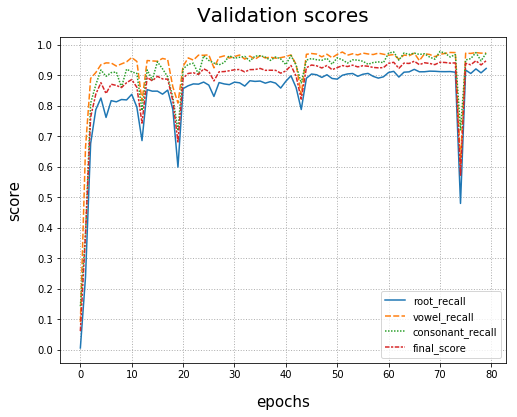

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(data=results_df.loc[:,['root_recall', 'vowel_recall', 
                                         'consonant_recall', 'final_score']], linestyle=None)
ax.set_xlabel('epochs', labelpad=15, fontsize=15)
ax.set_ylabel('score', labelpad=15, fontsize=15)
ax.set_title('Validation scores', pad=15, fontsize=20)
plt.yticks(np.arange(0, 1.1, step=0.1))
ax.grid(axis='both', linestyle=':', linewidth=1)

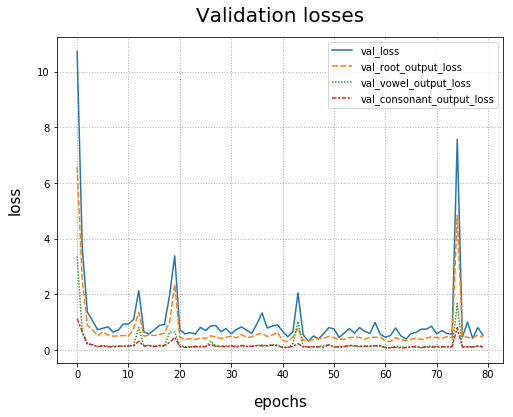

In [18]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1 = sns.lineplot(data=results_df.loc[:,['val_loss', 'val_root_output_loss', 'val_vowel_output_loss',
                                          'val_consonant_output_loss']], linestyle=None)
ax1.set_xlabel('epochs', labelpad=15, fontsize=15)
ax1.set_ylabel('loss', labelpad=15, fontsize=15)
ax1.set_title('Validation losses', pad=15, fontsize=20)
ax1.grid(axis='both', linestyle=':', linewidth=1)

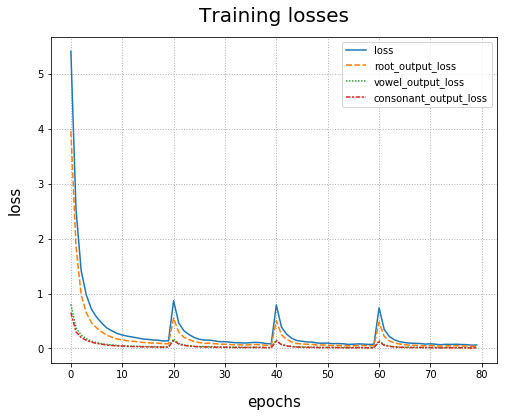

In [19]:
fig, ax2 = plt.subplots(figsize=(8,6))
ax2 = sns.lineplot(data=results_df.loc[:,['loss', 'root_output_loss','vowel_output_loss', 
                                          'consonant_output_loss']], linestyle=None)
ax2.set_xlabel('epochs', labelpad=15, fontsize=15)
ax2.set_ylabel('loss', labelpad=15, fontsize=15)
ax2.set_title('Training losses', pad=15, fontsize=20)
ax2.grid(axis='both', linestyle=':', linewidth=1)

# Inference

In [20]:
submission_df = pd.DataFrame(columns=['row_id', 'target'])
for i in range(4):    
    test_df = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/test_image_data_{i}.parquet')
    resized = test_df.iloc[:, 1:32333].values.reshape(-1, HEIGHT, WIDTH)
    cropped_df = crop_and_resize_images(test_df, resized, CROP_SIZE)
    test_index = cropped_df['image_id'].values.tolist()
    X_test = cropped_df.iloc[:,1:].values.reshape(-1, CROP_SIZE, CROP_SIZE, 1)
    
    del test_df
    del resized
    del cropped_df

    preds = trained_model.predict(X_test)

    root_preds = preds[0].argmax(axis=1).tolist()
    vowel_preds = preds[1].argmax(axis=1).tolist()
    consonant_preds = preds[2].argmax(axis=1).tolist()

    for image_id, root, vowel, consonant in zip(test_index, root_preds, vowel_preds, consonant_preds):
        root_row = {'row_id': image_id+'_grapheme_root', 'target':root}
        vowel_row = {'row_id': image_id+'_vowel_diacritic', 'target':vowel}
        consonant_row = {'row_id': image_id+'_vowel_diacritic', 'target':consonant}
        submission_df = submission_df.append(pd.DataFrame([root_row, vowel_row, consonant_row]), ignore_index=True)
        
    del preds
    del root_preds
    del vowel_preds
    del consonant_preds
    gc.collect
        
submission_df.to_csv('submission.csv',index=False)

100%|██████████| 3/3 [00:00<00:00, 364.99it/s]


In [21]:
display(submission_df)

,row_id,target
0,Test_0_grapheme_root,58
1,Test_0_vowel_diacritic,0
2,Test_0_vowel_diacritic,0
3,Test_1_grapheme_root,58
4,Test_1_vowel_diacritic,0
5,Test_1_vowel_diacritic,0
6,Test_2_grapheme_root,0
7,Test_2_vowel_diacritic,0
8,Test_2_vowel_diacritic,0
9,Test_3_grapheme_root,58
